In [ ]:
# Import basic libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# import re
# import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# Files checking
import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
train_df = pd.read_csv(os.path.join('../input', 'train_dataset.csv'))
test_df = pd.read_csv(os.path.join('../input', 'test_dataset.csv'))
val_df = pd.read_csv(os.path.join('../input', 'val_dataset.csv'))

Train shape: (148388, 3)
Test shape: (21199, 2)
Validation shape: (42396, 3)

Missing Values:
ID       0
Text     0
Label    0
dtype: int64

Duplicate Values in Train Dataset: 0


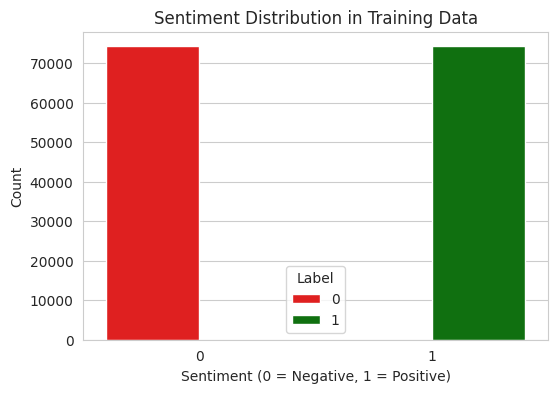

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


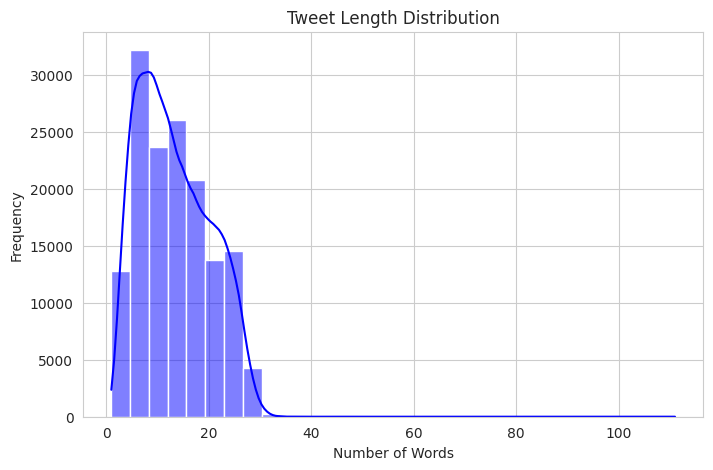

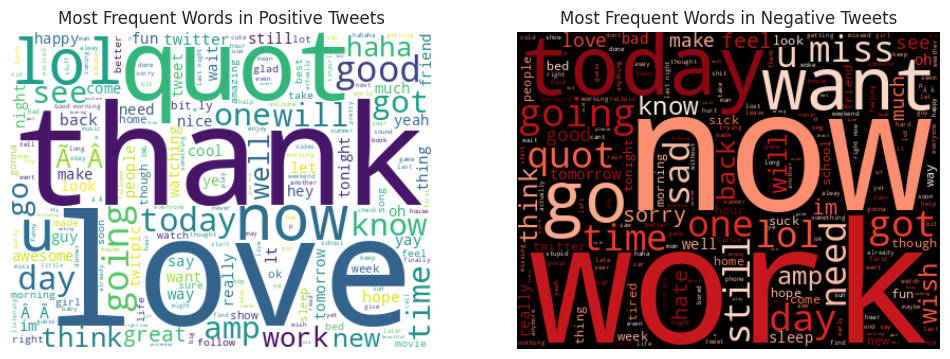

In [4]:
# EDA

# Display dataset shapes
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"Validation shape: {val_df.shape}")

# Check for missing values
print("\nMissing Values:")
print(train_df.isnull().sum())

# Check for duplicate tweets
print("\nDuplicate Values in Train Dataset:", train_df.duplicated().sum())

# Plot class distribution
sns.set_style("whitegrid")
plt.figure(figsize=(6,4))

sns.countplot(data=train_df, x="Label", hue="Label", palette={0: "red", 1: "green"})
plt.title("Sentiment Distribution in Training Data")
plt.xlabel("Sentiment (0 = Negative, 1 = Positive)")
plt.ylabel("Count")
plt.show()

# Compute text lengths
train_df["text_length"] = train_df["Text"].apply(lambda x: len(x.split()))

# Plot distribution of text length
plt.figure(figsize=(8,5))
sns.histplot(train_df["text_length"], bins=30, kde=True, color="blue")
plt.title("Tweet Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

from wordcloud import WordCloud

# Generate word clouds for positive and negative tweets
positive_tweets = " ".join(train_df[train_df["Label"] == 1]["Text"])
negative_tweets = " ".join(train_df[train_df["Label"] == 0]["Text"])

plt.figure(figsize=(12,5))

# Positive tweets word cloud
plt.subplot(1,2,1)
wordcloud_pos = WordCloud(width=400, height=300, background_color="white").generate(positive_tweets)
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Positive Tweets")

# Negative tweets word cloud
plt.subplot(1,2,2)
wordcloud_neg = WordCloud(width=400, height=300, background_color="black", colormap="Reds").generate(negative_tweets)
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Negative Tweets")

plt.show()

In [5]:
import pandas as pd

def preprocess_text(text):
    return text.lower()

# Load datasets
try:
    train_df = pd.read_csv('/kaggle/input/ai-2-deep-learning-for-nlp-homework-1/train_dataset.csv')
    val_df = pd.read_csv('/kaggle/input/ai-2-deep-learning-for-nlp-homework-1/val_dataset.csv')
    test_df = pd.read_csv('/kaggle/input/ai-2-deep-learning-for-nlp-homework-1/test_dataset.csv')
except FileNotFoundError as e:
    raise FileNotFoundError(f"Dataset file not found: {e}")

# Apply preprocessing
train_df['Text'] = train_df['Text'].apply(preprocess_text)
val_df['Text'] = val_df['Text'].apply(preprocess_text)
test_df['Text'] = test_df['Text'].apply(preprocess_text)

# Save cleaned datasets
train_df.to_csv('train_preprocessed.csv', index=False)
val_df.to_csv('val_preprocessed.csv', index=False)
test_df.to_csv('test_preprocessed.csv', index=False)

print("Preprocessing complete. Cleaned files saved.")

Preprocessing complete. Cleaned files saved.


In [6]:
# Set a random seed for reproducibility
RANDOM_SEED = 42

vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),    # Use unigrams and bigrams
    max_df=0.95,            # Ignore terms that appear in more than 80% of the documents
    min_df=3,               # Ignore terms that appear in fewer than 3% of the documents
    sublinear_tf=True  # Apply sublinear term frequency scaling
)

# Transform the text data into TF-IDF features
X_train_tfidf = vectorizer.fit_transform(train_df["Text"])  # Fit on training data
X_val_tfidf = vectorizer.transform(val_df["Text"])  # Transform validation data

# Extract labels
y_train = train_df["Label"]
y_val = val_df["Label"]

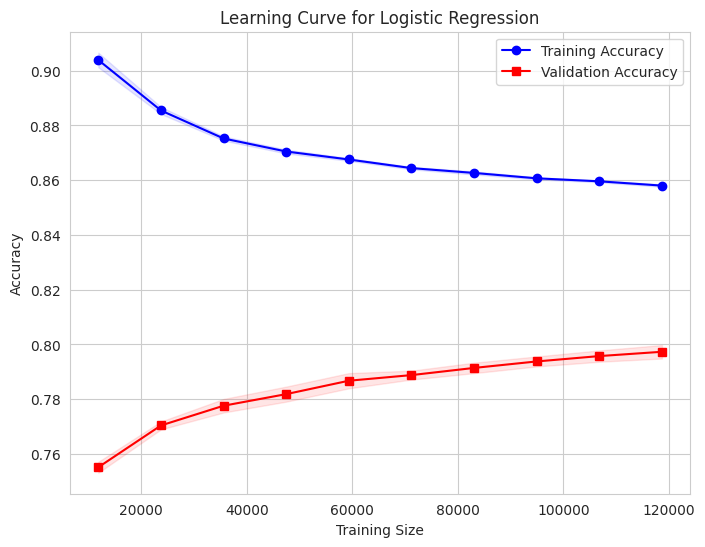

In [7]:
# Learning Curves

# Define training sizes (10% to 100% of training data)
train_sizes = np.linspace(0.1, 1.0, 10)

# Compute learning curves
train_sizes, train_scores, val_scores = learning_curve(
    LogisticRegression(random_state=RANDOM_SEED), X_train_tfidf, y_train, cv=5, scoring="accuracy", train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

# Compute mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(8,6))

# Plot training score
plt.plot(train_sizes, train_mean, label="Training Accuracy", color="blue", marker="o")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")

# Plot validation score
plt.plot(train_sizes, val_mean, label="Validation Accuracy", color="red", marker="s")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color="red")

# Labels and legend
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve for Logistic Regression")
plt.legend()
plt.show()

In [8]:
# Model training and evaluation

# Initialize Logistic Regression model
model = LogisticRegression(
    C=1.4,               # Regularization strength
    n_jobs=-1,            # Use all CPU cores for cross-validation
    random_state=RANDOM_SEED
)

# Train the model
model.fit(X_train_tfidf, y_train)

# Make predictions on validation set
y_pred = model.predict(X_val_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.20f}")

# Detailed classification report
print("Classification Report:\n", classification_report(y_val, y_pred))

# --- Generate Submission File for Kaggle ---

# Transform test data using the same TF-IDF vectorizer
X_test_tfidf = vectorizer.transform(test_df["Text"])

# Predict the labels for test data
test_predictions = model.predict(X_test_tfidf)

# Create submission dataframe
submission_df = pd.DataFrame({
    "ID": test_df["ID"],  # Ensure this matches the test dataset IDs
    "Label": test_predictions  # Predicted labels (0 or 1)
})

# Save to CSV file (without index)
submission_df.to_csv("submission.csv", index=False)

print("Submission file 'submission.csv' created successfully!")

Accuracy: 0.80425040098122468901
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.80      0.80     21197
           1       0.80      0.81      0.80     21199

    accuracy                           0.80     42396
   macro avg       0.80      0.80      0.80     42396
weighted avg       0.80      0.80      0.80     42396

Submission file 'submission.csv' created successfully!
